# Classifying Crisis Reports and Natural Language Processing

## EDA, Problem Statement, Modelling and Scaling Strategies

### The Official Blurb:

Imagine this scenario: A region’s stability is in decline due to unrest, crime and terrorism. We need a better understanding of this humanitarian crisis to decide how best to support the situation, gained through the information contained within a set of reports.

The challenge: We have acquired news articles containing potentially relevant information. Using these, we need you to use historical reports to determine the topics for new articles so that they can be classified and prioritised. This will allow analysts to focus on only the most pertinent details of this developing crisis.

For Further Information: https://www.datasciencechallenge.org/challenges/2/growing-instability/

The [official guide](guide.pdf) is also available in this project's directory.

## The Problem Statement: Classify topics on the text of Guardian articles from a pre-defined 'crisis' topic dictionary.

A topic labeled training set will be provided with articles ranging from 1999 to 2014 and an unlabeled test set of articles will be provided as well with articles ranging from 2015 to 2016 for which classification of topics is required. Our test data .json file has 7581 unclassified articles.

#### Understanding the Guardian's topic tagging:

As the topics that we aim to classify are 'crisis' related, they will be by nature less frequent than the topic of most articles, like culture or tech news for example. The topics that we are given are also B-level topics, as in they are subtopics of larger encompassing topics like 'world', for example the crisis topic 'iraq' would be a sub topic of 'world'.

A visual example of the header of the Guardian's website from which the data has been parsed from, shows us the A-level topics like UK, world, fashion etc. 

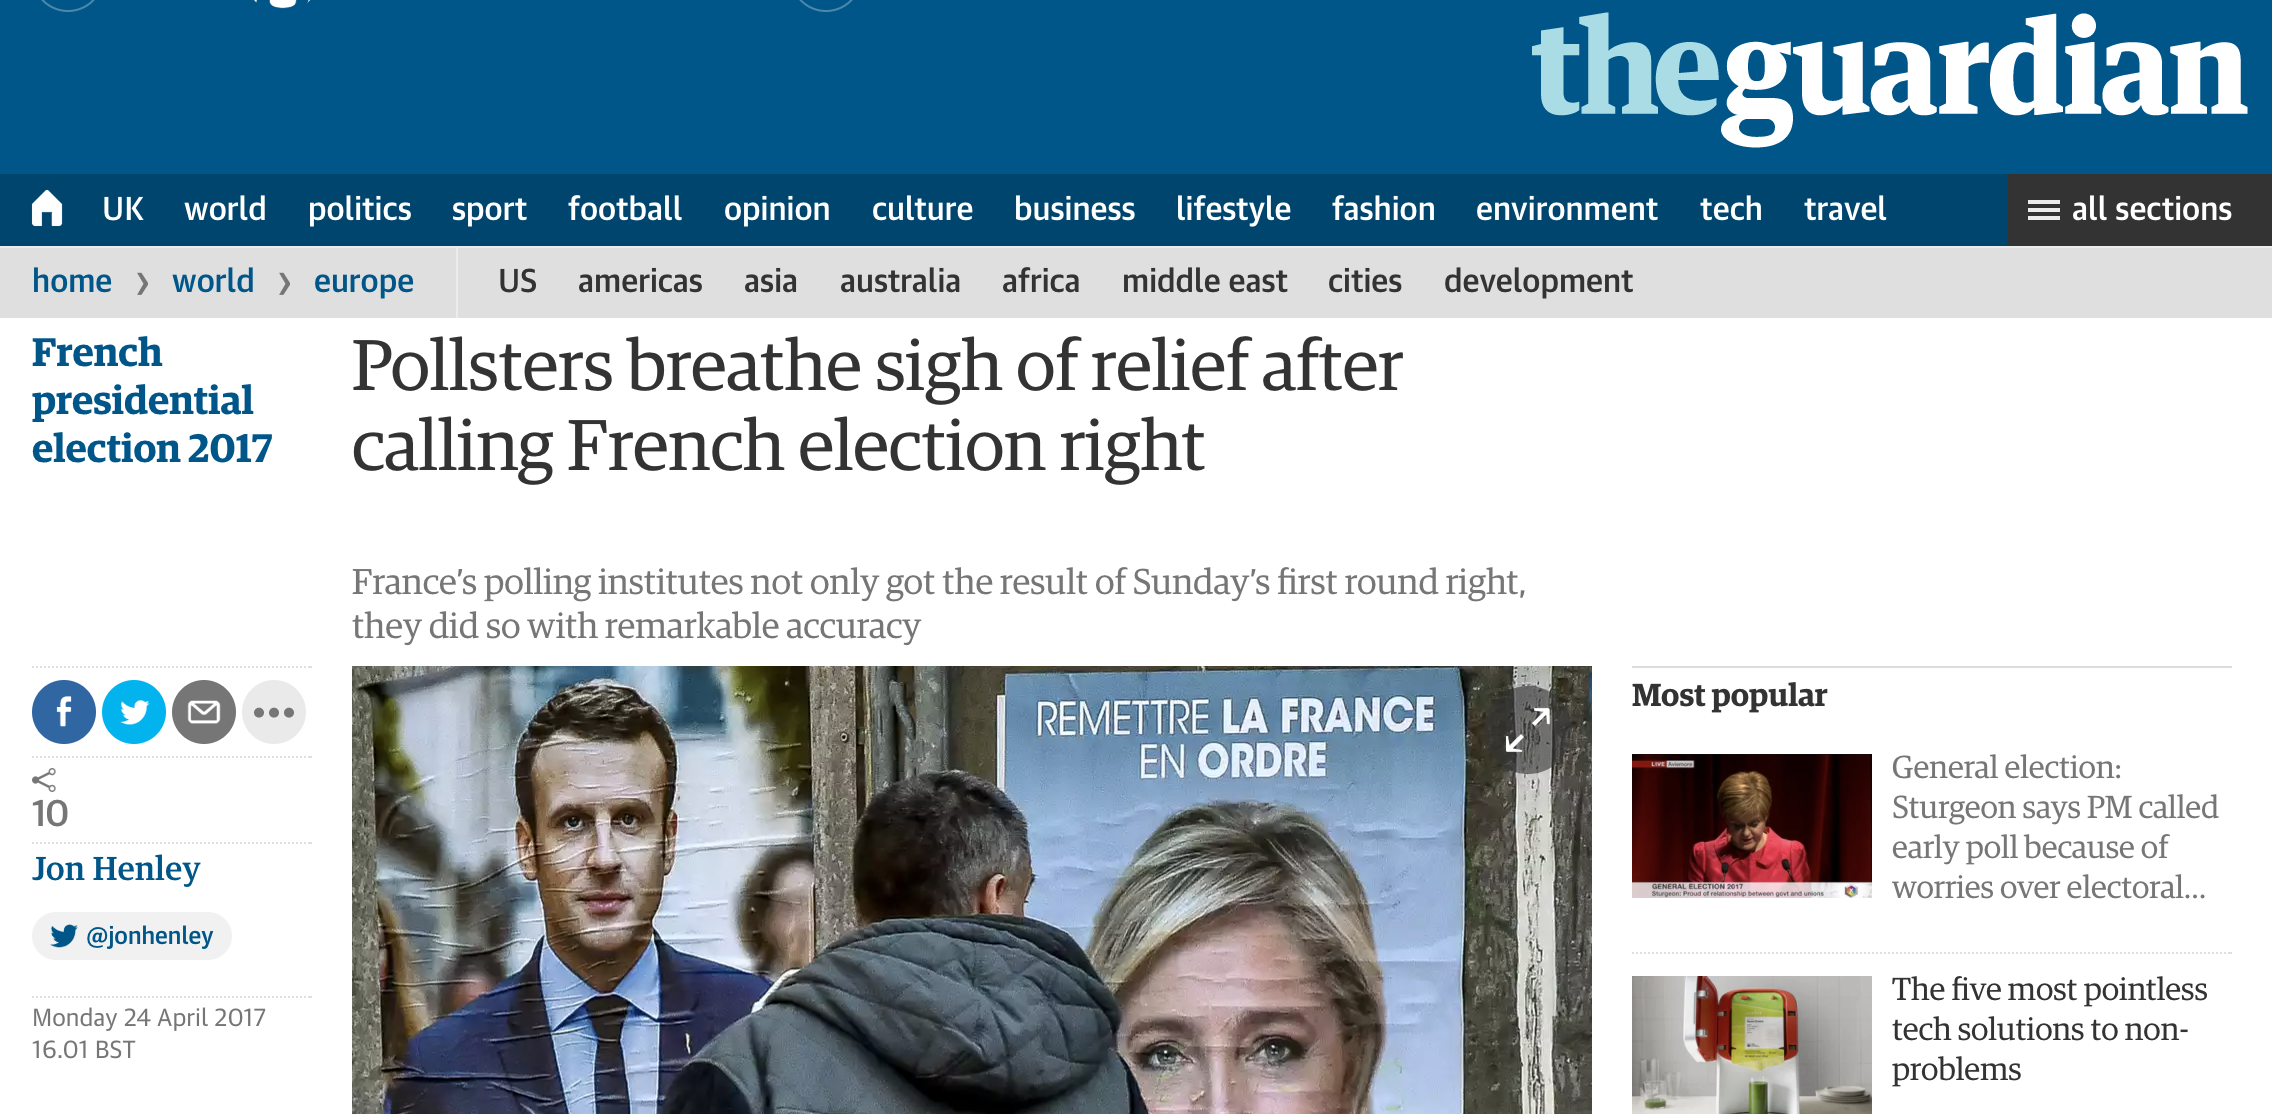

In [8]:
Image(filename='./Assets/images/guardian_header.png')

Whereas at the footer of the article (shown below), we will see the actual topics that we will aim to predict, for example the topic 'france' is included in our topic dictionary.

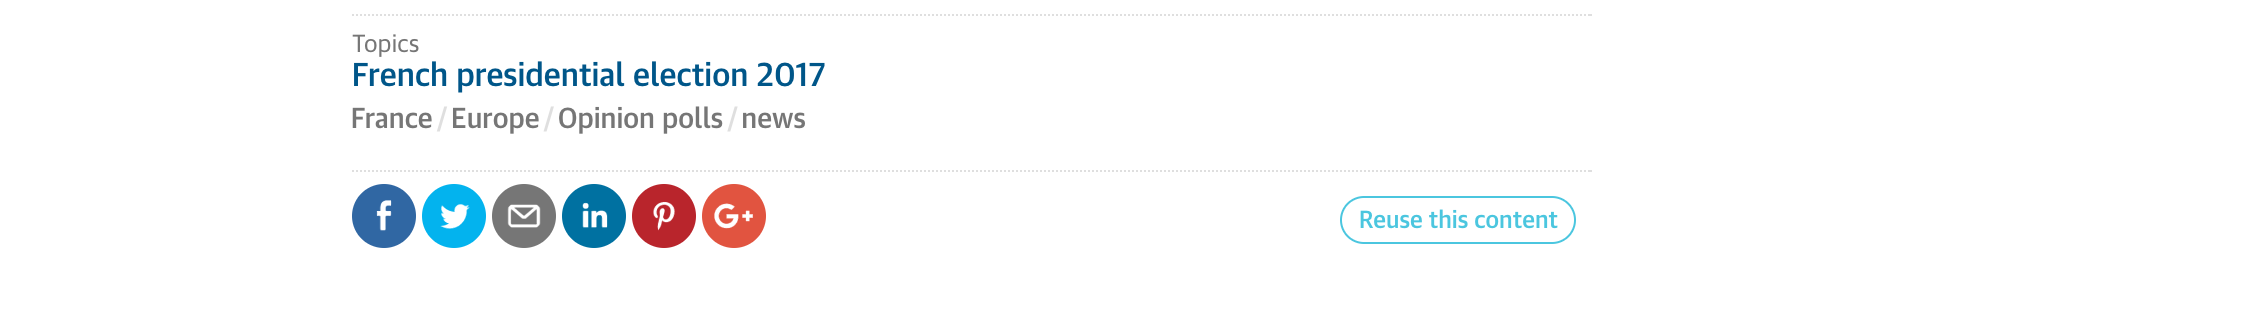

In [9]:
Image(filename='./Assets/images/guardian_footer.png')

For each article in our test set, we will have to predict a 1 or a 0 per topic in our topic dictionary and submit a csv file to be scored on the F1 metric.

### Scoring Metric - F1 Score

The submitted results will be scored using the F1 score, defined as:

2×TP / (2×TP + FP + FN)

Where:

TP are the true positives
FP are the false positives
FN are the false negatives
There are two main methods in practice for averaging TPs, FPs and FNs to calculate an F1 score for multi-label classification problems. For this challenge we will use the micro-averaged F1 score. This is obtained by summing the TPs, FPs and FNs over each individual decision for the test examples, to produce a global average in which each test example (document) is weighted equally.

### Imports:

In [10]:
from IPython.display import Image
import json
import pandas as pd
import pprint
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# MODELLING AND METRICS IMPORTS
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

# TEXT PREPROCESSING IMPORTS
import spacy
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
import string
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

# IMPORT BASE ESTIMATOR AND TRANSFORMERMIXIN FOR PIPELINE STEP CREATION
from sklearn.base import BaseEstimator, TransformerMixin

# MISCELLANEOUS 
from pprint import pprint
import itertools

In [11]:
# SET SEABORN STYLE
sns.set(context='paper', style='white', palette='bone', font='sansserif', font_scale=1.5, color_codes=False, rc=None)

# SET FONT DICTIONARY
font = {'family': 'sansserif',
        'color':  'black',
        'weight': 'normal',
        'variant': 'small-caps',
        'size': 14,
        }

### Data Upload and Clean

In [12]:
# DEFINE DIRECTORY PATH
path_to_json = 'TrainingData/'

# CREATE LIST OF FILES FROM THE DIRECTORY
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

In [13]:
# DEFINE PANDAS DATAFRAME
df = pd.DataFrame()

# LOOP THROUGH FILES, READ IN JSON AND BUILD DATAFRAME
for index, js in enumerate(json_files):
    json_data = pd.read_json(os.path.join(path_to_json, js), 'r')
    df = df.append(json_data)

In [14]:
# CHECK NUMBER OF ARTICLES 
print "The Total number of articles in our dataset is", df.shape[0]

The Total number of articles in our dataset is 1600462


We have 1.6 million articles in our training set, which is split into an A and B data frame for each year from 1999 to 2014. We are also given a test set for articles which is missing topic data, checking the head and tail our dataframe should confirm this with the years.

In [15]:
# CHECK 2: PRINT DF HEAD
df.head()

,TrainingData
1999a_TrainingData_00001,"{u'bodyText': u'Anthony Newley, who has died o..."
1999a_TrainingData_00002,{u'bodyText': u'Experiments at the University ...
1999a_TrainingData_00003,{u'bodyText': u'Bejewelled white gauntlet rais...
1999a_TrainingData_00004,{u'bodyText': u'With a note of discord being s...
1999a_TrainingData_00005,{u'bodyText': u'Harry Callista did not do the ...


In [16]:
# CHECK 3: PRINT DF TAIL
df.tail()

,TrainingData
2014b_TrainingData_52903,{u'bodyText': u'Australian journalists could f...
2014b_TrainingData_52904,{u'bodyText': u'The Australian prime minister ...
2014b_TrainingData_52905,{u'bodyText': u'Increasing uncertainty about b...
2014b_TrainingData_52906,{u'bodyText': u'The Senate has refused to allo...
2014b_TrainingData_52907,{u'bodyText': u'If there's one thing that defi...


The u in front of the bodytext indicates our JSON element is encoded as a unicode string, which is convenient for us for future text manipulation of the articles. However first we will need to split the JSON element into its three components:

- bodyText
- webPublicationDate
- topics

Three new columns will be created in our dataframe for this.

In [17]:
# SPLITTING THE ELEMENTS OF THE JSON INTO TEXT, PUBLICATION DATE AND TOPICS
df['text'] = df.TrainingData.apply(lambda x: x['bodyText'])
df['pubdate'] = df.TrainingData.apply(lambda x: x['webPublicationDate'])
df['topics'] = df.TrainingData.apply(lambda x: x['topics'])

In [18]:
# CHECKING OUR DATAFRAME POST SPLITTING
df.head()

,TrainingData,text,pubdate,topics
1999a_TrainingData_00001,"{u'bodyText': u'Anthony Newley, who has died o...","Anthony Newley, who has died of cancer aged 67...",16-04-1999,[]
1999a_TrainingData_00002,{u'bodyText': u'Experiments at the University ...,"Experiments at the University of Illinois, Kir...",20-02-1999,"[culture, media]"
1999a_TrainingData_00003,{u'bodyText': u'Bejewelled white gauntlet rais...,"Bejewelled white gauntlet raised in blessing, ...",27-05-1999,[usnews]
1999a_TrainingData_00004,{u'bodyText': u'With a note of discord being s...,With a note of discord being struck about the ...,04-06-1999,"[usnews, sport]"
1999a_TrainingData_00005,{u'bodyText': u'Harry Callista did not do the ...,Harry Callista did not do the usual kind of ve...,06-02-1999,[]


In [19]:
# DROP THE ORIGINAL JSON COLUMN AND THE INDEX
df.reset_index(inplace=True, drop=True)
df.drop('TrainingData', axis=1, inplace=True)

In [20]:
# CHECK SHAPE
df.shape

(1600462, 3)

In [21]:
# CHECK HEAD OF DATAFRAME
df.head()

,text,pubdate,topics
0,"Anthony Newley, who has died of cancer aged 67...",16-04-1999,[]
1,"Experiments at the University of Illinois, Kir...",20-02-1999,"[culture, media]"
2,"Bejewelled white gauntlet raised in blessing, ...",27-05-1999,[usnews]
3,With a note of discord being struck about the ...,04-06-1999,"[usnews, sport]"
4,Harry Callista did not do the usual kind of ve...,06-02-1999,[]


In [22]:
# CHECK FOR ANY NULL OR MISSING VALUES:
df.isnull().sum()

text       0
pubdate    0
topics     0
dtype: int64

In [23]:
# CHECK DTYPES:
df.dtypes

text       object
pubdate    object
topics     object
dtype: object

The dataset is complete and the dtypes are also all objects as expected, the text is the article and encoded as unicode, pubdate is set as date and topics is a series of lists of topics.

#### A Note about PubDate:
For the time being we will ignore pubDate as our topic modelling will be mostly based upon the text in the articles themselves but we will be keeping it in for its predictive purposes for later, to see how much value it provides, our test data does include pubDate information.

Let's take a closer look at a single article in our data:

In [24]:
# SELECT ARTICLE FROM DF AT INDEX 20
df['text'][20]

u"The new head of the Merseyside drugs squad was paying tribute to the retiring head. Like all impromptu speeches it had clearly been written out several times in his own hand. 'Why,' he asked rhetorically, 'are we happy when someone of Derek's experience and glamour - not only locally, regionally, nationally but internationally - is leaving this organisation?' He paused for breath or dramatic effect. Unwisely. 'Because you've got his job,' said a voice from the floor of Lennon's Bar. Derek shook hands warmly with the heckler. His retirement cake was iced with a razor blade and a scattering of pills and poppers. This is Mersey Blues (BBC2), a documentary series which sounds like a drug itself. Mike Culverhouse, the new head of the drug squad, had a reputation for balancing the books. As he told the troops, 'I am not prepared at any price to overspend the budget. We will end this financial year with a penny in credit.' If there were any cries of 'Good old Mike!' I missed them. Money was

Looking at the text in this article, we can see unicode for special characters like the pound sign \xa3 that will have to be monitored once we try to turn the text of the articles into feature matrices. Overall it seems the article text resembles a typical article and having looked through multiple articles, it seems there is no difference in structure of them, just length and content.

The data that we have been given on the outset looks rather simple but it is much more complicated than one would expect as we are given essentially only given 1 predictor variable column from which we will need to engineer features that correspond to our topics that need to be classified. The publication date is a feature that we will bring into the modelling after trying to predict based on features generated from the text itself first.

The topic column is essentially our target variable that needs to be unpacked into multiple target columns, we will see just how many from the topic dictonary:

### Topics to be Classified:

As the problem statement indicated, it will be necessary to identify and classify reports which are high priority, which in this case, they have provided us conveniently with a dictionary of topics. Let's take a look:

In [25]:
# LOOK AT TOPIC DICTIONARY AND GET A TOPIC COUNT
topic_file = open('./topicDictionary.txt', 'r')
topics = topic_file.read().split('\r\n')
print "Number of topics in dictionary:", len(topics)

Number of topics in dictionary: 160


Our solution submission will have to be a matrix of predicted 1s and 0s for each article in a corpus of 7581 unclassified articles.

In [26]:
# VISUAL CHECK OF TOPIC DICTIONARY
print topics

['activism', 'afghanistan', 'aid', 'algerianhostagecrisis', 'alqaida', 'alshabaab', 'antiwar', 'arabandmiddleeastprotests', 'armstrade', 'australianguncontrol', 'australiansecurityandcounterterrorism', 'bastilledaytruckattack', 'belgium', 'berlinchristmasmarketattack', 'bigdata', 'biometrics', 'bokoharam', 'bostonmarathonbombing', 'britisharmy', 'brusselsattacks', 'cameroon', 'carers', 'charliehebdoattack', 'chemicalweapons', 'clusterbombs', 'cobra', 'conflictanddevelopment', 'controversy', 'criminaljustice', 'cybercrime', 'cyberwar', 'darknet', 'dataprotection', 'debate', 'defence', 'deflation', 'drones', 'drugs', 'drugspolicy', 'drugstrade', 'earthquakes', 'ebola', 'economy', 'egypt', 'encryption', 'energy', 'espionage', 'ethics', 'europeanarrestwarrant', 'europeancourtofhumanrights', 'events', 'extradition', 'famine', 'farright', 'firefighters', 'forensicscience', 'france', 'francetrainattack', 'freedomofspeech', 'genevaconventions', 'germany', 'guncrime', 'hacking', 'hashtags', 'he

Let's visualize our topic dictionary over the 1.6 million articles:

In [27]:
# SET UP A NEW DATAFRAME FROM OUR TOPIC DICTIONARY
topicdf = pd.DataFrame(topics, columns=['topic'])

# TIME HOW LONG IT TAKES TO LOOP THROUGH 1.6 MILLION ROWS OF LISTS OF TOPICS
time1 = time.time()

# ADD THE COUNT FOR EACH TOPIC TO OUR TOPIC DICTIONARY DATAFRAME
for x in topics:
    counter = 0
    for list in df['topics']:
        for y in list:
            if y == x:
                counter += 1
    topicdf.loc[topicdf['topic'] == x, 'count'] = int(counter)  
    topicdf.loc[topicdf['topic'] == x, 'ratio'] = round(float(counter)/df.shape[0],2)

time2 = time.time()
time_in_s = (time2-time1)
print 'Function takes around %0.3f seconds to run' % (time_in_s)

Function takes around 241.484 seconds to run


In [28]:
# SORT OUR TOPIC DICTIONARY DATA FRAME BY COUNT
topicdf = topicdf.sort_values('count', ascending=False)

# CALCULATE % OF TOTAL TRAINING DATA
topicdf['pct'] = (topicdf['count']/float(df.shape[0]))*100

# RESET INDEX AND PRINT TOP 10 ARTICLES BY COUNT
topicdf.reset_index(drop=True, inplace=True)

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sansserif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


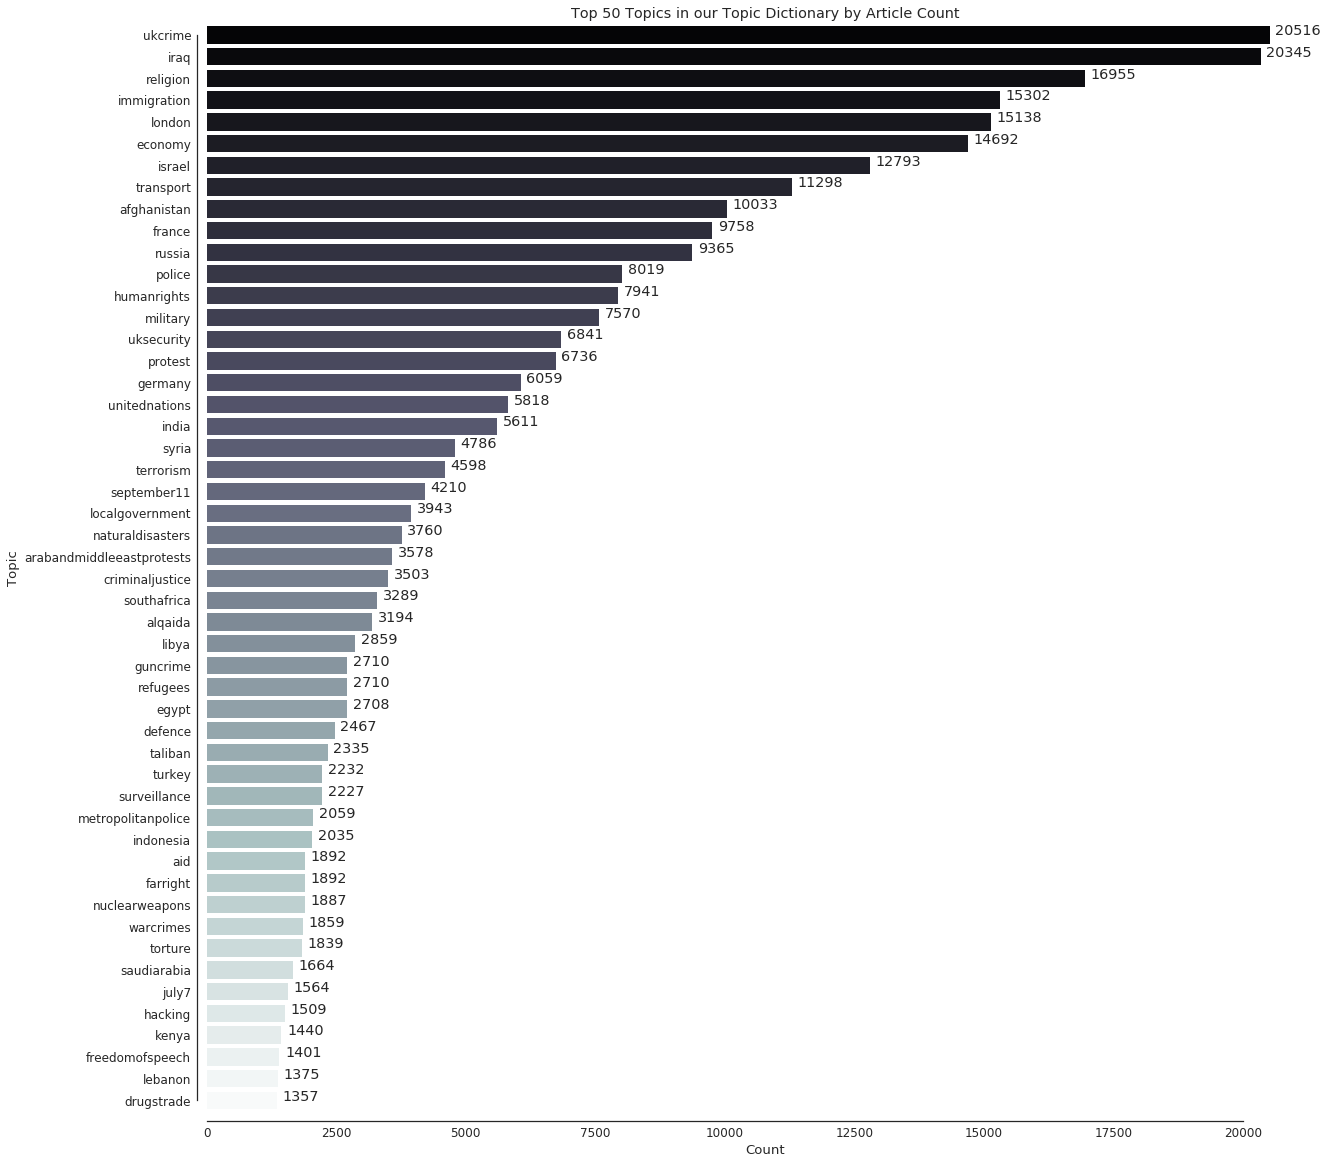

In [29]:
# PLOT THE DICTIONARY COUNT VISUALLY
f, ax = plt.subplots(figsize=(20,20))
sns.barplot(topicdf['count'][0:50], topicdf['topic'][0:50], orient='h', palette='bone', ax=ax)
sns.despine(offset=10, trim=True)
ax.set_ylabel('Topic')
ax.set_xlabel('Count')
ax.set_yticklabels(topicdf['topic'][0:50])
ax.set_title('Top 50 Topics in our Topic Dictionary by Article Count')
for p in ax.patches:
    ax.text(p.get_x()+p.get_width()+110, p.get_y()+p.get_height()/2., '%d' % int(p.get_width()))
plt.show()

In [30]:
# TOP 15 AND LOWEST 15 TOPICS BY COUNT AND PERCENT MAKE UP OF TRAINING DATA
pd.concat([topicdf.head(15),topicdf.tail(15)])

,topic,count,ratio,pct
0,ukcrime,20516.0,0.01,1.281880
1,iraq,20345.0,0.01,1.271195
2,religion,16955.0,0.01,1.059382
3,immigration,15302.0,0.01,0.956099
4,london,15138.0,0.01,0.945852
5,economy,14692.0,0.01,0.917985
6,israel,12793.0,0.01,0.799332
7,transport,11298.0,0.01,0.705921
8,afghanistan,10033.0,0.01,0.626881
9,france,9758.0,0.01,0.609699


What has become blatantly clear from just going through our full data set is that we have severe class imbalances in the topics we need to classify, the topic with the most articles from our topic dictionary only makes up 1.28%. We will have to come up with strategies to account for these major class imbalances.

In addition, we have some topics in our dictionary that aren't in our training data, the entire list of topics with no articles in our dataset are:

- zikavirus
- turkeycoupattempt
- tunisiattack2015
- sanbernandinoshooting
- peaceandreconciliation
- parisattacks
- orlandoterrorattack
- munichshooting
- francetrainattack
- charliehebdoattack
- brusselsattacks
- berlinchristmasmarketattack
- bastilledaytruckattack
- activism

This means that we will have to classify topics that have not even occurred, we have the names of these topics for this challenge but it indicates early on that this may require some form of machine learning or some unsupervised learning methods but I will proceed with supervised first to get a feel first. Additionally data from outside the training set provide is allowed to be utilized to train the model and as such we may incorporate some articles relating to these topics after trying to predict the other topics first.

### Sandbox Testing and Modeling

First let's create a sample from the 1.6 million articles to work on, as this is our sandbox testing, we will just be testing out with two small samples of 1000 records each. 

Due to the relatively small sample size and because we will eventually be training our data on the the full data, the effect of 'contamination' on our data is minimal and this is just our sandbox testing and modelling for scaling, just to garner an idea of how long modelling will take and what kind of accuracy we will be looking at.

In [31]:
# CREATE A SAMPLE TO TRAIN OUR SANDBOX MODEL ON WHICH WE WILL SCALE UP LATER
df_test = df.sample(1000, random_state=42) 
df_test.reset_index(drop=True, inplace=True)

In [32]:
# CREATE A SAMPLE TO TEST OUR SANDBOX MODEL ON, USING A DIFFERENT RANDOM_STATE TO ENSURE DIFFERENT SAMPLE
df_test2 = df.sample(1000, random_state=43)
df_test2.reset_index(drop=True, inplace=True)

As we will not be provided the A-level tag in our test data, we will only need to create target columns of 1s and 0s for topic presences for our pre-defined topics. We will keep our original topic list column after just for checking purposes.

In [33]:
# CREATE A NEW COLUMN FOR EACH TOPIC IN OUR TOPICS AND ASSIGN A 1 IF THE ARTICLE HAS THAT TOPIC OR A 0 IF IT DOES NOT
time1 = time.time()
for topic in topics:
    for index, list in enumerate(df_test['topics']):
        if topic in list:
            df_test.ix[index, topic] = 1
        else:
            df_test.ix[index, topic] = 0
time2 = time.time()
time_in_s = (time2-time1)
print 'Function takes around %0.3f seconds to run' % (time_in_s)

Function takes around 70.778 seconds to run


In [34]:
#RERAN FOR DF_TEST2
time1 = time.time()
for topic in topics:
    for index, list in enumerate(df_test2['topics']):
        if topic in list:
            df_test2.ix[index, topic] = 1
        else:
            df_test2.ix[index, topic] = 0
time2 = time.time()
time_in_s = (time2-time1)
print 'Function takes around %0.3f seconds to run' % (time_in_s)

Function takes around 71.565 seconds to run


With a sample of 1000, to create target columns of 1s and and 0s for 160 topics it took 61.828 seconds, to do this for our full training data set it will take over a full day to run on a MacBook Pro with 8GB of RAM and make our target columns. It is evident that scaling up computing power is necessary.

As this is just our EDA and Sandbox testing, the cleaning steps conducted thus far will be combined into a function for use later as it is not feasible to create target columns on our full data frame right now, as the run time will be close to 36 hours.

In [35]:
def datacleaner(dfm):
    time1 = time.time()
    
    dfm['text'] = dfm['TrainingData'].apply(lambda x: x['bodyText'])
    dfm['pubdate'] = dfm['TrainingData'].apply(lambda x: x['webPublicationDate'])
    dfm['topics'] = dfm['TrainingData'].apply(lambda x: x['topics'])
    
    dfm.reset_index(inplace=True, drop=True)
    dfm.drop('TrainingData', axis=1, inplace=True)
    
    for topic in topics:
        for index, list in enumerate(dfm['topics']):
            if topic in list:
                dfm.ix[index, topic] = 1
            else:
                dfm.ix[index, topic] = 0
    
    time2 = time.time()
    
    time_in_s = (time2-time1)
    
    print 'Function takes around %0.3f seconds to run' % (time_in_s)
    
    return dfm

In [36]:
# VISUAL CHECK OF TARGET COLUMNS PER TOPIC
df_test.head()

,text,pubdate,topics,activism,afghanistan,aid,algerianhostagecrisis,alqaida,alshabaab,antiwar,...,unitednations,usguncontrol,values,warcrimes,warreporting,weaponstechnology,womeninbusiness,woolwichattack,worldmigration,zikavirus
0,Not that many people even in Southampton and M...,21-04-2002,"[football, sport]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"A mummified, stunted corpse of a four-year old...",19-09-2013,[uk],0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,With turnout approaching 80% and voters queuin...,15-05-2001,[],0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"The WikiLeaks founder, Julian Assange, today h...",03-12-2010,"[world, media, usnews]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Gordon Brown today said it was ""vital"" to make...",08-12-2004,"[globaldevelopment, politics, debtrelief, uk, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# SHAPE CHECK 
print df_test.shape
print df_test2.shape

(1000, 163)
(1000, 163)


In [38]:
# CHECK THE ARTICLES IN OUR SAMPLE THAT WE HAVE IN OUR TRAINING DATA SAMPLE FROM OUR TOPIC DICTIONARY (TOP 10)
pd.DataFrame(df_test[topics].sum(), columns=['Count']).sort_values('Count', ascending=False)[0:10]

,Count
economy,14.0
london,14.0
russia,14.0
israel,13.0
iraq,11.0
afghanistan,8.0
religion,8.0
ukcrime,7.0
uksecurity,6.0
humanrights,6.0


The Count in the above table gives us an indication of how many articles we have from these topics out of 1000 in our sample, i.e we have 11 articles with the topic Iraq.

In [39]:
# CHECK THE ARTICLES IN OUR TEST DATA SAMPLE
pd.DataFrame(df_test2[topics].sum(), columns=['Count']).sort_values('Count', ascending=False)[0:10]

,Count
ukcrime,17.0
london,12.0
iraq,10.0
humanrights,10.0
transport,9.0
economy,8.0
immigration,8.0
protest,7.0
france,6.0
india,6.0


In [40]:
# LOOKING CLOSER AT ARTICLES ABOUT IRAQ IN OUR SAMPLE
df_test[df_test['iraq'] == 1].iloc[:,0:3]

,text,pubdate,topics
79,Top Democrats have thrown American politics in...,25-08-2007,"[iraq, world, middleeast, usnews]"
110,The founder of whistleblowing website WikiLeak...,04-11-2010,"[world, afghanistan, media, middleeast, united..."
249,"With fewer people buying papers nowadays, ever...",14-04-2003,"[iraq, media, middleeast, world]"
291,"Thank you all very much. Distinguished guests,...",29-06-2004,"[nato, politics, turkey, middleeast, iraq, wor..."
383,Before the sun had even risen yesterday mornin...,12-01-2003,"[iraq, uk, middleeast, uknews, world]"
493,AN AMERICAN F-16 jet fired missiles into a res...,20-06-2004,"[iraq, world, middleeast]"
617,A secret intelligence assessment issued immedi...,05-02-2004,"[iraq, politics, uk, middleeast, world]"
759,The government today indicated that it believe...,18-12-2002,"[politics, middleeast, iraq, foreignpolicy, uk..."
832,For the five years that British forces camped ...,11-10-2010,"[iraq, business, middleeast, world]"
836,"The Syrian government, under intense pressure ...",28-02-2005,"[iraq, world, middleeast, syria]"


Let's see if we can predict any of the Iraq articles in our test sample with just a simple logistic regression using a count vectorizer.

We will begin by training a logistic regression model on count vectorized text from articles in our first sample with the topic iraq using 100 features.

In [41]:
# SET UP A COUNT VECTORIZER WITH AN NGRAM RANGE OF (1,4) USING STOP WORDS TO FIT ON IRAQ TOPIC ARTICLES IN OUR SAMPLE
iqcv = CountVectorizer(max_features=100, ngram_range=(1,4), stop_words='english').fit(df_test[df_test['iraq']==1]['text'])

In [42]:
# LOOKING AT THE COUNT VECTORIZER VOCABULARY OF TEXT FROM ARTICLES ABOUT IRAQ
print iqcv.vocabulary_

{u'country': 21, u'want': 91, u'years': 98, u'nation': 65, u'city': 16, u'world': 96, u'past': 70, u'saddam hussein': 78, u'readers': 74, u'broader': 11, u'face': 30, u'trying': 88, u'day': 23, u'government': 37, u'months': 62, u'war': 92, u'muslim': 64, u'year': 97, u'america': 5, u'baghdad': 8, u'month': 61, u'iran': 47, u'iraq': 48, u'history': 39, u'syria': 83, u'american': 6, u'justice': 51, u'000': 0, u'like': 55, u'including': 45, u'middle east': 59, u'liberty': 54, u'make': 57, u'human': 42, u'iraqi': 49, u'council': 20, u'foreign': 32, u'democracy': 24, u'report': 75, u'did': 26, u'tower': 86, u'long': 56, u'peace': 71, u'freedom': 34, u'military': 60, u'democratic': 25, u'nations': 66, u'best': 10, u'east': 27, u'basra': 9, u'people': 72, u'time': 84, u'rights': 76, u'future': 35, u'power': 73, u'al': 3, u'europe': 29, u'ago': 2, u'great': 38, u'hussein': 44, u'hope': 40, u'alliance': 4, u'told': 85, u'human rights': 43, u'work': 95, u'forces': 31, u'broader middle': 12, u'se

In [43]:
# TRANSFORM OUR TEXT INTO COUNT VECTORIZED MATRIX AND FIT INTO A DATAFRAME
X = pd.DataFrame(iqcv.transform(df_test.text).todense(), columns=iqcv.get_feature_names())

In [44]:
# PRINT HEAD OF COUNT VECTOR MATRIX
X.head()

,000,added,ago,al,alliance,america,american,assad,baghdad,basra,...,violence,want,war,weapons,women,work,world,year,years,yesterday
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,3,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,2,4,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,2,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,8,3,4,0


Let's standardize our feature matrix.

In [45]:
# SET UP STANDARD SCALER FOR STANDARDIZATION OF FEATURES
ss = StandardScaler()

# STANDARDIZE OUR FEATURE MATRIX
Xs = ss.fit_transform(X)

In [46]:
# VISUAL CHECK OF STANDARDIZED FEATURE MATRIX
Xs

array([[-0.40629539, -0.33615063, -0.40875369, ..., -0.60373776,
        -0.57096427,  1.98049453],
       [-0.40629539,  5.66653918,  1.3015128 , ...,  0.44441808,
         2.22445445, -0.39847788],
       [-0.40629539, -0.33615063, -0.40875369, ..., -0.07965984,
        -0.57096427, -0.39847788],
       ..., 
       [ 0.52131966, -0.33615063, -0.40875369, ..., -0.60373776,
        -0.57096427,  0.79100833],
       [ 1.44893471, -0.33615063, -0.40875369, ..., -0.07965984,
        -0.57096427, -0.39847788],
       [-0.40629539, -0.33615063, -0.40875369, ...,  0.968496  ,
         1.52559977, -0.39847788]])

In [47]:
# SET UP A LOGISTIC REGRESSION MODEL AND FIT TO TRAINING STANDARDIZED FEATURE TF-IDF MATRIX AND TARGET CLASSIFICATION
lr = LogisticRegression()
lr.fit(Xs,df_test.iraq)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [48]:
# CREATE A PLOTTING FUNCTION FOR CONFUSION MATRIX FOR REUSE
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.bone):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict=font)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white",
                fontdict=font)
    plt.ylabel('True label', fontdict=font, fontsize=10)
    plt.xlabel('Predicted label', fontdict=font, fontsize=10)
    plt.show()

In [49]:
# CONVERT OUR TEST TEXT FRAME INTO A DENSE MATRIX FROM A SPARSE COUNT VECTOR MATRIX WITH COLUMN NAMES FROM THE VECTORIZER
X2 =pd.DataFrame(iqcv.transform(df_test2.text).todense(), columns=iqcv.get_feature_names())

In [50]:
# STANDARDIZE OUR FEATURE MATRIX
X2s = ss.fit_transform(X2)

In [51]:
# VISUAL CHECK OF STANDARDIZED FEATURE MATRIX
X2s

array([[-0.39892062, -0.3149652 , -0.40784627, ..., -0.61843738,
        -0.64811257, -0.35687088],
       [ 0.54863429, -0.3149652 , -0.40784627, ..., -0.61843738,
        -0.64811257,  0.89530765],
       [-0.39892062,  1.75717428,  1.16079324, ...,  0.39539439,
         0.19578401,  2.14748619],
       ..., 
       [-0.39892062, -0.3149652 ,  2.72943275, ..., -0.61843738,
         2.72747375, -0.35687088],
       [-0.39892062, -0.3149652 , -0.40784627, ..., -0.61843738,
         0.19578401, -0.35687088],
       [-0.39892062, -0.3149652 , -0.40784627, ...,  1.91614205,
        -0.64811257, -0.35687088]])

Cross-Validated Score: 0.992


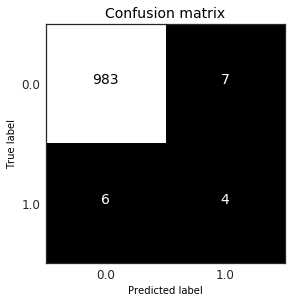

In [52]:
# TEST OUR LOGISTIC REGRESSION ON STANDARDIZED FEATURE MATRIX AND CROSS VALIDATE WITH 5 FOLDS
print "Cross-Validated Score:", cross_val_score(lr, X2s, df_test2.iraq, cv=5).mean()
plot_confusion_matrix(confusion_matrix(df_test2.iraq, lr.predict(X2s)), lr.classes_)

In [53]:
# COMPARE TO BASELINE
print df_test2.iraq.value_counts()
print "Baseline Accuracy is:", 990./1000

0.0    990
1.0     10
Name: iraq, dtype: int64
Baseline Accuracy is: 0.99


Basically 99% of our articles are not from our topic, we are predicting the 1%, so we should be aiming for almost 100% .

In [54]:
# F1 SCORE
print "F1 Score", round(f1_score(df_test2.iraq, lr.predict(X2s)),2)

F1 Score 0.38


With our logistic regression trained on 100 features on the articles from our training sample we got an F1 score of 0.38, which if you look at the confusion matrix above should give you a better understanding, we have 7 misclassified articles as Iraq topics where they should have been not about Iraq, we correctly identified 4 out of 10 articles with the topic Iraq and misclassified 6 articles as being not about Iraq where they should be classified as Iraq.

It is expected that our model doesn't work well because we are only using standardized count vectors for words and these words will probably be in many articles unrelated to iraq, we have to start to use term frequency and inverse document frequency to assign weights to these words and maybe they will improve in our model, also adding a penalty to the large number of features we have will help.

We are also only exploring a single model whereas there are many options for models, with many hyperparameters to be tuned, we also have to pay attention to sample sizing as well, given the large class imbalances we have.

### Scaling up our search with GridSearch and Pipeline with Multiple Models for the topic iraq

As the solution requires the production of a matrix of 1s and 0s for 160 topics, it essentially means a repetition of steps 160 times, this would require the usage of a pipeline or customized functions and nested for loops for topics as the manual process would not be efficient.

#### Pseudo code for sample pipeline:
1. Create list of models to be instantiated.
2. Set Parameters for pipeline steps through which the model will be fitted.
3. For loop for each model
4. Establish pipeline steps - count vectorizing a feature matrix from article text > tf-idf etc.
5. Gridsearch the models with parameters established.
6. Print metrics to judge results of pipeline - confusion matrix, f1 score etc.

#### Features to be added to full scaled pipeline:
These features have not been added for now to avoid clutter and they are not needed yet.
1. Pickle or Joblib for saving models for reuse.
2. Models will be tabled with their gridsearch results appended and visualized.
3. Hyperparameter tuning per specific model.

In [55]:
# LOAD MODELS TO BE TESTING - MORE TO BE ADDED
models = [KNeighborsClassifier(),
          LogisticRegression(),
          DecisionTreeClassifier(),
          SVC(),
          RandomForestClassifier(),
          ExtraTreesClassifier(),
          SGDClassifier(),
          Perceptron(),
          PassiveAggressiveClassifier(),
          RidgeClassifier(),
          BernoulliNB(),
          MultinomialNB(),
          ]

In [56]:
# SAMPLE PARAMETER GRID FOR PIPELINE MODEL SEARCH - USING STOP-WORDS FOR TESTING PURPOSES ONLY
parameters = {
       'vect__stop_words': ('english', None),

#      # SAMPLE PIPELINE PARAMATERS
#     'vect__max_df': (0.5, 0.75, 1.0),
#     'vect__max_features': (5, 10, 20, 100, 1000),
#     'vect__ngram_range': ((1, 1),(1, 2),(1,3),(1,4)),  # unigrams or bigrams
#     'tfidf__use_idf': (True, False),
#     'tfidf__norm': ('l1', 'l2', None),
#     'clf__alpha': (0.00001, 0.000001),
#     'clf__penalty': ( 'l2', 'elasticnet'),
#     'clf__n_iter': (10, 50, 80),
}

# NOTE:
# HYPERPARAMETERS GRIDS WILL HAVE TO BE ADDED PER EACH SPECIFIC MODEL

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 34.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 34.2min finished


Function takes around 2055.895 seconds to run
Grid Search Best Score: 0.989
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.0


//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


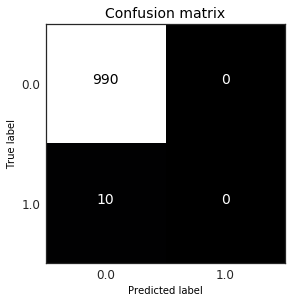

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.8s finished


Function takes around 13.397 seconds to run
Grid Search Best Score: 0.988
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.0


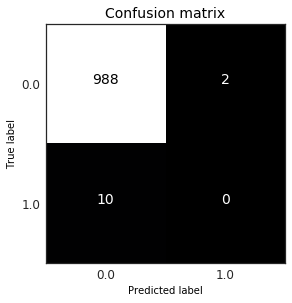

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...it=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    7.9s finished


Function takes around 11.770 seconds to run
Grid Search Best Score: 0.986
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.642857142857


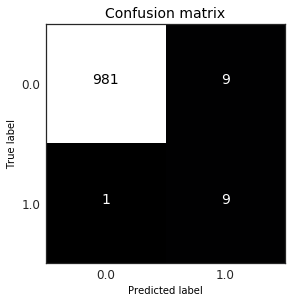

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   19.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   19.6s finished


Function takes around 26.874 seconds to run
Grid Search Best Score: 0.989
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.0


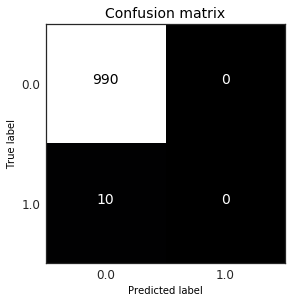

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.2s finished


Function takes around 8.972 seconds to run
Grid Search Best Score: 0.989
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.0


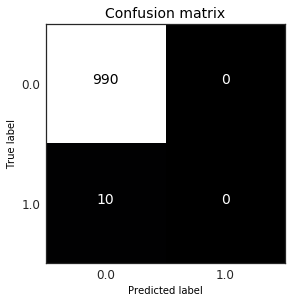

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...timators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.0s finished


Function takes around 8.882 seconds to run
Grid Search Best Score: 0.989
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.0


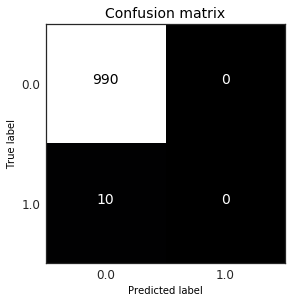

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...   penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.5s finished


Function takes around 9.678 seconds to run
Grid Search Best Score: 0.955
Grid Search Best Params: {'vect__stop_words': None}
F1 Score: 0.15


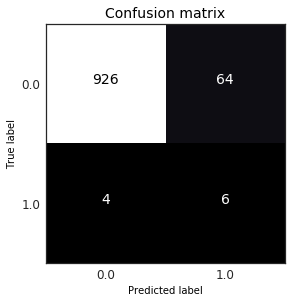

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=5, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...n_iter=5, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.7s finished


Function takes around 8.497 seconds to run
Grid Search Best Score: 0.944
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.177215189873


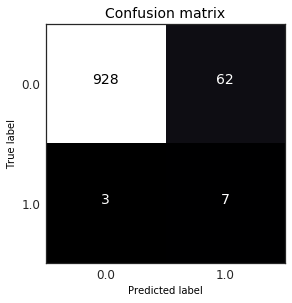

PassiveAggressiveClassifier(C=1.0, class_weight=None, fit_intercept=True,
              loss='hinge', n_iter=5, n_jobs=1, random_state=None,
              shuffle=True, verbose=0, warm_start=False)
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...', n_iter=5, n_jobs=1, random_state=None,
              shuffle=True, verbose=0, warm_start=False))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.4s finished


Function takes around 7.964 seconds to run
Grid Search Best Score: 0.988
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.0


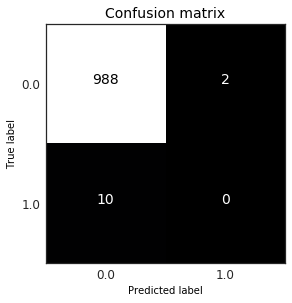

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.5s finished


Function takes around 9.792 seconds to run
Grid Search Best Score: 0.988
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.0


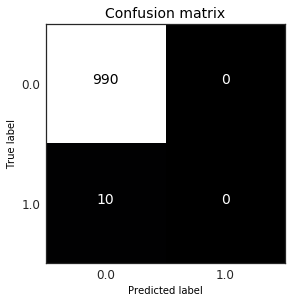

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...e, with_std=True)), ('clf', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.8s finished


Function takes around 8.535 seconds to run
Grid Search Best Score: 0.989
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.0


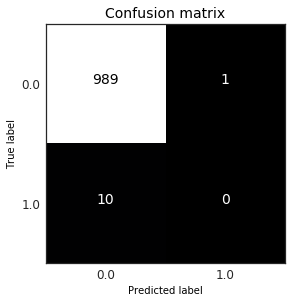

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...th_mean=False, with_std=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.0s finished


Function takes around 8.897 seconds to run
Grid Search Best Score: 0.975
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.285714285714


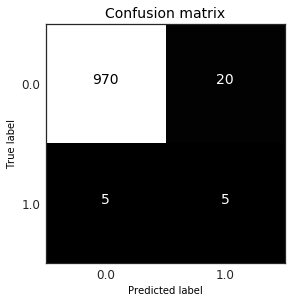

In [57]:
for model in models:
    pipeline = Pipeline([
        ('vect', CountVectorizer()), # STANDARD COUNT VECTORIZER USING STOP WORDS
        ('tfidf', TfidfTransformer()), # TERM FREQUENCY - INVERSE DOCUMENT FREQUENCY
        ('ss', StandardScaler(with_mean=False)), # MEAN = FALSE DUE TO SPARSE MATRIX
        ('clf', model), # RUNS THROUGH ALL THE MODELS
    ])
    time1 = time.time()
    
    
    print model
    print pipeline
    
    # PIPELINE AND PARAMETER GRID INCLUDED IN GRIDSEARCHCV, N_JOBS=-1 TO USE ALL CORES FOR COMPUTING
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
    grid_search.fit(df_test.text, df_test.iraq)
    
    time2 = time.time()
    time_in_s = (time2-time1)
    
    print 'Function takes around %0.3f seconds to run' % (time_in_s)
    print "Grid Search Best Score:", grid_search.best_score_
    print "Grid Search Best Params:", grid_search.best_params_
    
    predictions = grid_search.best_estimator_.predict(df_test2.text)
    
    print "F1 Score:", f1_score(df_test2.iraq, predictions)
    
    cnf_matrix = confusion_matrix(df_test2.iraq, predictions)
    plot_confusion_matrix(cnf_matrix, classes=grid_search.best_estimator_.classes_)


#### Testing fit and gridsearch on more than 1 topic - Sample Approach to Scaling  Up:

In [58]:
# SET UP A SMALL TOPIC LIST AND MODELS FOR A GRIDSEARCH
topiclist = ['iraq', 'russia']
modelslist = [LogisticRegression(), SGDClassifier()]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.3s finished


Function takes around 9.003 seconds to run
Grid Search Best Score: 0.988
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.0


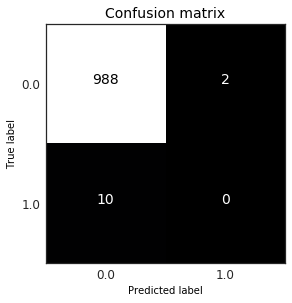

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...   penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.5s finished


Function takes around 8.492 seconds to run
Grid Search Best Score: 0.943
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.133333333333


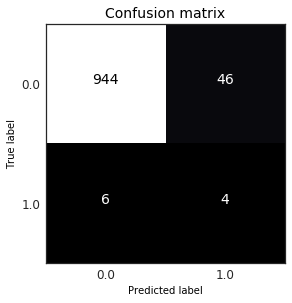

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.5s finished


Function takes around 8.093 seconds to run
Grid Search Best Score: 0.986
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.0


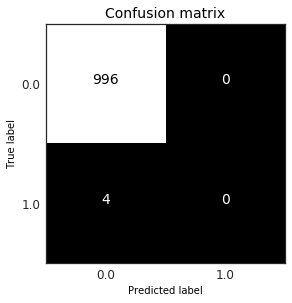

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...   penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.5s finished


Function takes around 8.019 seconds to run
Grid Search Best Score: 0.96
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.275862068966


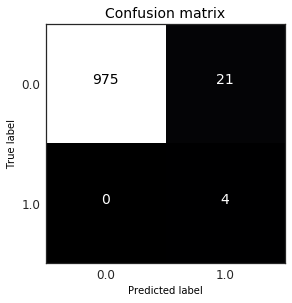

In [59]:
# SAME GRIDSEARCH AS ABOVE WITH HIGHER TIER FOR LOOP FOR RUNNING THROUGH TOPICS
for topic in topiclist:    
    for model in modelslist:
        pipeline = Pipeline([
            ('vect', CountVectorizer()), # STANDARD COUNT VECTORIZER USING STOP WORDS
            ('tfidf', TfidfTransformer()), # TERM FREQUENCY - INVERSE DOCUMENT FREQUENCY
            ('ss', StandardScaler(with_mean=False)), # MEAN = FALSE DUE TO SPARSE MATRIX
            ('clf', model), # RUNS THROUGH ALL THE MODELS
        ])
        time1 = time.time()
        print model
        print pipeline

        # PIPELINE AND PARAMETER GRID INCLUDED IN GRIDSEARCHCV, N_JOBS=-1 TO USE ALL CORES FOR COMPUTING
        grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
        grid_search.fit(df_test.text, df_test[topic])
        time2 = time.time()
        time_in_s = (time2-time1)
        print 'Function takes around %0.3f seconds to run' % (time_in_s)
        print "Grid Search Best Score:", grid_search.best_score_
        print "Grid Search Best Params:", grid_search.best_params_

        predictions = grid_search.best_estimator_.predict(df_test2.text)

        print "F1 Score:", f1_score(df_test2[topic], predictions)

        cnf_matrix = confusion_matrix(df_test2[topic], predictions)
        plot_confusion_matrix(cnf_matrix, classes=grid_search.best_estimator_.classes_)

        # PICKLE MODEL SAVE TO ASSETS FOLDER

Running through a sample pipeline, we did not see much improvement on the original logistic regression we trained on articles with topic Iraq from df_test, as we are using a pipeline here, the models produced count vectors for the words based on all articles. This indicates a sampling problem, we have to either produce our count vectors on only articles with our topic and then transform the article texts into a count vector matrix, then into a term-frequency, inverse document frequency, then standardize and then run the model on it.

However we do have an idea of our basic approach for modelling multiple labels with a gridsearch approach with a nested for loop that we can fine tune by introducing hyperparameter testing for the models and other pipeline steps. We have the scope to add a PCA as well into the pipeline after standardization to reduce our count vectors, tf-idf matrix into its principal components, however as we will be working with sparse matrices, we cannot use PCA but Truncated Singular Value Decomposition which is also a dimensionality reduction technique that works on our count tf-idf vectors rather than on a covariance matrix.

#### Issues to consider with using Pipelines

Due to our class imbalances and pipelines in Sklearn being unable to handle transformation of the target, we have to either:

1. Preprocess the training data into a count vector matrix that we will have to resample using SMOTE and then perform a TF-IDF transformation on the vector and then standardize and do the same for the test data before predicting the labels.

2. Choose a smaller sample manually with an oversampling of articles with the topic and then run everything through the pipeline.

3. Use the pipeline with the class imbalances.

When oversampling training data to change the class frequencies in the training set, you implicitly notify the  classifier to expect the test set to have those same class frequencies. These class frequencies influence the decision boundary, if the test set has differing class frequencies, then the classification boundary may be incorrect and performance will be sub-optimal. On the flip side with such severe class imbalances, the model may not be able to predict certain topics at all.

Additionally running Count Vectorizer through the pipeline and fitting on our training data without oversampling, we will be generating mostly word vectors that will not fit our topic classification due to class imbalances, it may be prudent to create a custom pipeline step for our Count Vectorizer to fit only on text from articles with our topic but we will come to that later.

In [60]:
# SAMPLE PSEUDO CODE PIPELINE STEP TO BE IMPLEMENTED.
class CVecTopic(BaseEstimator, TransformerMixin):
    def __init__(self, topic):
        self.topic = topic

    def fit(self, df, *args):
        cvec = CountVectorizer()
        cvec.fit(df[self.topic])
        return self
    
    def transform(self, df, *args):
        return df

### More Preprocessing Thoughts and Testing:

It is also evident that we will need to do some preprocessing on our text before plugging into our pipeline as we are only count vectorizing and transforming into a tf-idf matrix using all words (minus stop-words), we can reduce the terms, we can stem or lemmatize and do much more before even count vectorizing.

#### Most Frequent Words and Stop-Words

In [61]:
cntvect = CountVectorizer(binary=True, stop_words='english', max_features=50)

# TIME HOW LONG IT TAKES TO LOOP THROUGH 1.6 MILLION ARTICLES
time1 = time.time()
cntvectfit = cntvect.fit(df['text'])
common_words = cntvectfit.vocabulary_.keys()
time2 = time.time()
time_in_s = (time2-time1)
print 'Function takes around %0.3f seconds to run' % (time_in_s)
print common_words

Function takes around 3725.107 seconds to run
[u'think', u'today', u'year', u'does', u'told', u'work', u'far', u'000', u'home', u'people', u'day', u'make', u'old', u'good', u'set', u'little', u'say', u'government', u'come', u'week', u'just', u'don', u'public', u'like', u'said', u'big', u'right', u'going', u'know', u'long', u'man', u'new', u'second', u'years', u'world', u'best', u'says', u'need', u'high', u'life', u'end', u'uk', u'london', u'great', u'way', u'want', u'place', u'time', u'did', u'10']


In [62]:
print cntvect.get_stop_words()

frozenset(['all', 'six', 'less', 'being', 'indeed', 'over', 'move', 'anyway', 'fifty', 'four', 'not', 'own', 'through', 'yourselves', 'go', 'where', 'mill', 'only', 'find', 'before', 'one', 'whose', 'system', 'how', 'somewhere', 'with', 'thick', 'show', 'had', 'enough', 'should', 'to', 'must', 'whom', 'seeming', 'under', 'ours', 'has', 'might', 'thereafter', 'latterly', 'do', 'them', 'his', 'around', 'than', 'get', 'very', 'de', 'none', 'cannot', 'every', 'whether', 'they', 'front', 'during', 'thus', 'now', 'him', 'nor', 'name', 'several', 'hereafter', 'always', 'who', 'cry', 'whither', 'this', 'someone', 'either', 'each', 'become', 'thereupon', 'sometime', 'side', 'two', 'therein', 'twelve', 'because', 'often', 'ten', 'our', 'eg', 'some', 'back', 'up', 'namely', 'towards', 'are', 'further', 'beyond', 'ourselves', 'yet', 'out', 'even', 'will', 'what', 'still', 'for', 'bottom', 'mine', 'since', 'please', 'forty', 'per', 'its', 'everything', 'behind', 'un', 'above', 'between', 'it', 'nei

Looking at the stop words it is clear that we may be able to add some of the most frequent words to the list as they will not provide much differentiating if their count vectors are high across all articles. However we have to be careful as words like London occur very frequently but also appear as a topic itself in our topic dictionary.

When we run our full pipeline on our data, we will update our stop-words by removing articles not pertinent to any of our topics in our topic dictionary.

In [64]:
# PSEUDO CODE CHECK FOR FREQUENT WORDS VS. TOPICS TO ADD TO STOP WORDS LIST

for x in common_words:
    if x not in topics:
        stop_words.append(x)

#### Tokenization, Stemming, Lemmatization and Named Entity Recognition:

A few options are available such as NLTK, Spacy, Gensim, Textblob for processing the text for our use, ideally we would like this in a customized transformer which would plug in to our pipeline.

Let's take a look at an individual article to identify some sample steps to identify a topic, besides count vectorization and tf-idf.

In [99]:
# LOOKING AT A SAMPLE ARTICLE WITH MULTIPLE TOPICS
df_test.iloc[110]['topics']

[u'world',
 u'afghanistan',
 u'media',
 u'middleeast',
 u'unitednations',
 u'iraq',
 u'humanrights',
 u'usnews']

Of these topics, only afghanistan, unitednations, humanrights, iraq are in our topic dictionary, let's see if we can identify the individual features of the said article manually.

In [102]:
df_test.iloc[110]['text']

u'The founder of whistleblowing website WikiLeaks has called on the US to investigate alleged abuses by its troops in Afghanistan and Iraq, saying it has a "proud tradition" of self-scrutiny. Julian Assange says the US has not started any investigations into the alleged incidents detailed in thousands of documents published by WikiLeaks and has instead concentrated on tracking down those responsible for the leaks and on hounding his group. Last month, WikiLeaks published 400,000 US field reports containing evidence that US soldiers handed over detainees to a notorious Iraqi torture squad. This followed a the publication of 75,000 documents in the summer revealing how coalition forces killed hundreds of civilians in unreported incidents in Afghanistan. Assange made his comments ahead of a big diplomatic set piece in Geneva tomorrow, when America\'s human rights record comes under scrutiny before the UN human rights council for the first time. Every UN member is subject to what is called

The abbreviation UN is seen throughout and can indicate the topic 'unitednations', the country name 'Afghanistan' is listed as well and can be indicative of the topic 'afghanistan'

Running a named entity recognition using Spacy and manually choosing a few vectors myself,



In [112]:
# NOTE - RAN IN ANOTHER NOTEBOOK DUE TO UTF-8 ENCODING ISSUE
# CREATE A DATAFRAME FOR IRAQ ARTICLES
df_iraq = df_test[df_test['iraq'] == 1]

# LOAD SPACY PARSER
en_nlp = spacy.load('en')
parser = spacy.en.English()

# LOOP THROUGH TEXT OF IRAQI ARTICLES AND FIND NAMED ENTITIES
named_ents = []
for x in df_iraq['text']:
    parsed2 = parser(x)
    named_ents.append(parsed2.ents)

In [114]:
# SAMPLE NAMED ENTITIES FOR A SINGLE ARTICLE
 (Iraq,
  almost two weeks,
  Nato,
  Serbian,
  Slobodan Milosevic,
  the United States,
  Britain,
  Saddam Hussein,
  West,
  Last month,
  Rambouillet,
  US,
  British,
  Iraq,
  March 19 not,
  May 1991,
  the Gulf war,
  US,
  Britain,
  France,
  Iraq,
  US,
  British,
  Iraqi,
  Saddam,
  Balkans,
  Washington,
  two,
  Saddam,
  Al Thawra,
  Iraqi,
  Sunday,
  US,
  Nato,
  Yugoslavia,
  fifth,
  a day,
  US,
  Iraqis,
  Yugoslav,
  Martin Indyk,
  state,
  London,
  al-Hayat,
  US,
  Iraqi,
  Saddam,
  Kosovo,
  the Middle East,
  Kosovo,
  Baghdad,
  one,
  Muslim,
  Tuesday,
  Americans,
  British,
  French,
  Kurds,
  Shi'ite Muslims,
  Baghdad,
  the United Nations,
  yesterday,
  the UN Security Council,
  three,
  February,
  Iraq,
  Kosovo,
  Iraq,
  1991,
  UN,
  The UN oil-for-,
  Iraq,
  Iraq,
  quarter,
  five,
  Only 41,
  83 per,
  The UN Development Programme,
  cost $7 billion,
  1990,
  1990,
  second,
  605,
  Kuwaitis,
  Iraq,
  Kuwait,
  1990-91,
  Mass Destruction,
  Iraq,
  UN Special Commission,
  Unscom,
  Baghdad,
  Operation Desert Fox,
  December,
  15-member,
  Russia,
  France,
  China,
  Iraq,
  US,
  Britain,
  the Security Council,
  three,
  Kosovo,
  Saddam,
  UN,
  Iraq,
  Iraq,
  Washington,
  London,
  now)

In [110]:
# CREATE A VOCABULARY FOR IRAQI ARTICLES
vocab = ['saddam', 'shiite', 'kurdish', 'dinars', 'baghdad', 'tariq', 'mosul', 'iraqi', 'gulf war', 'al-amiriya', 'hussein']

In [55]:
# LOAD MODELS TO BE TESTING - MORE TO BE ADDED
models = [KNeighborsClassifier(),
          LogisticRegression(),
          DecisionTreeClassifier(),
          SVC(),
          RandomForestClassifier(),
          ExtraTreesClassifier(),
          SGDClassifier(),
          Perceptron(),
          PassiveAggressiveClassifier(),
          RidgeClassifier(),
          BernoulliNB(),
          MultinomialNB(),
          ]

In [56]:
# SAMPLE PARAMETER GRID FOR PIPELINE MODEL SEARCH - USING STOP-WORDS FOR TESTING PURPOSES ONLY
parameters = {
       'vect__stop_words': ('english', None),

#      # SAMPLE PIPELINE PARAMATERS
#     'vect__max_df': (0.5, 0.75, 1.0),
#     'vect__max_features': (5, 10, 20, 100, 1000),
#     'vect__ngram_range': ((1, 1),(1, 2),(1,3),(1,4)),  # unigrams or bigrams
#     'tfidf__use_idf': (True, False),
#     'tfidf__norm': ('l1', 'l2', None),
#     'clf__alpha': (0.00001, 0.000001),
#     'clf__penalty': ( 'l2', 'elasticnet'),
#     'clf__n_iter': (10, 50, 80),
}

# NOTE:
# HYPERPARAMETERS GRIDS WILL HAVE TO BE ADDED PER EACH SPECIFIC MODEL

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        st...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   12.1s finished


Function takes around 19.811 seconds to run
Grid Search Best Score: 0.982
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.470588235294


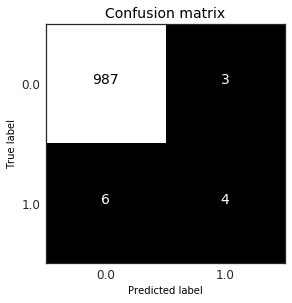

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        st...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   11.9s finished


Function takes around 15.118 seconds to run
Grid Search Best Score: 0.982
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.727272727273


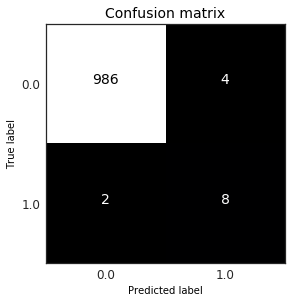

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        st...it=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.8s finished


Function takes around 12.448 seconds to run
Grid Search Best Score: 0.98
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.7


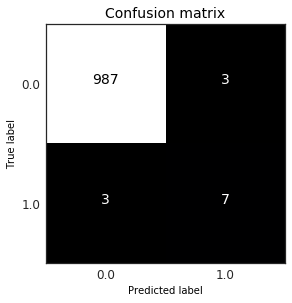

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        st...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.6s finished


Function takes around 12.607 seconds to run
Grid Search Best Score: 0.984
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.428571428571


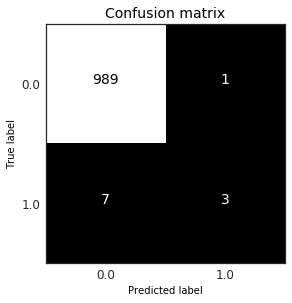

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        st...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.7s finished


Function takes around 12.449 seconds to run
Grid Search Best Score: 0.986
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.555555555556


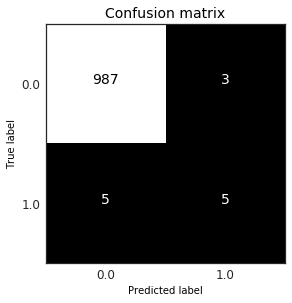

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        st...timators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   10.2s finished


Function takes around 13.159 seconds to run
Grid Search Best Score: 0.982
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.545454545455


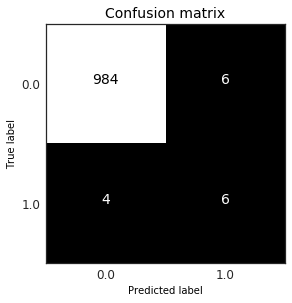

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        st...   penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.6s finished


Function takes around 12.573 seconds to run
Grid Search Best Score: 0.981
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.133333333333


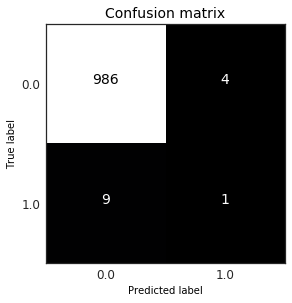

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=5, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        st...n_iter=5, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.6s finished


Function takes around 12.773 seconds to run
Grid Search Best Score: 0.983
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.666666666667


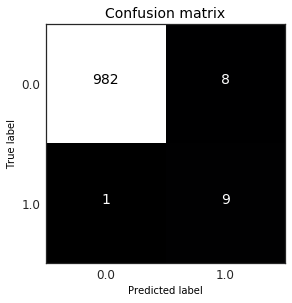

PassiveAggressiveClassifier(C=1.0, class_weight=None, fit_intercept=True,
              loss='hinge', n_iter=5, n_jobs=1, random_state=None,
              shuffle=True, verbose=0, warm_start=False)
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        st...', n_iter=5, n_jobs=1, random_state=None,
              shuffle=True, verbose=0, warm_start=False))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.9s finished


Function takes around 12.794 seconds to run
Grid Search Best Score: 0.983
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.454545454545


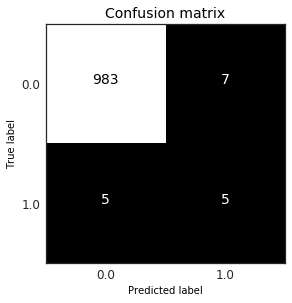

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        st...True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.7s finished


Function takes around 12.486 seconds to run
Grid Search Best Score: 0.978
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.583333333333


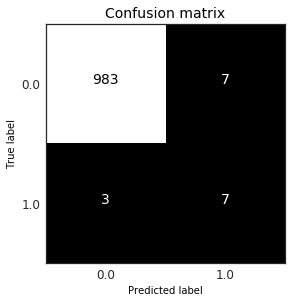

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        st...e, with_std=True)), ('clf', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   14.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   14.3s finished


Function takes around 19.956 seconds to run
Grid Search Best Score: 0.991
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.72


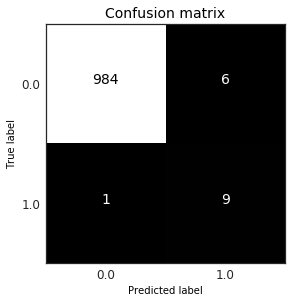

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        st...th_mean=False, with_std=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   12.4s finished


Function takes around 18.373 seconds to run
Grid Search Best Score: 0.976
Grid Search Best Params: {'vect__stop_words': 'english'}
F1 Score: 0.210526315789


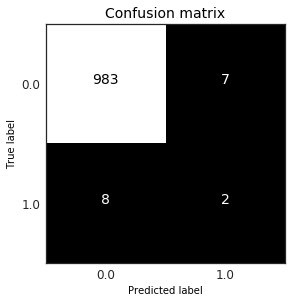

In [123]:
for model in models:
    pipeline = Pipeline([
        ('vect', CountVectorizer(vocabulary=vocab, lowercase=True, ngram_range=(1,2))), # STANDARD COUNT VECTORIZER USING STOP WORDS
        ('tfidf', TfidfTransformer()), # TERM FREQUENCY - INVERSE DOCUMENT FREQUENCY
        ('ss', StandardScaler(with_mean=False)), # MEAN = FALSE DUE TO SPARSE MATRIX
        ('clf', model), # RUNS THROUGH ALL THE MODELS
#         ('pca', TruncatedSVD()), # RUNS THROUGH ALL THE MODELS
    ])
    time1 = time.time()
    
    
    print model
    print pipeline
    
    # PIPELINE AND PARAMETER GRID INCLUDED IN GRIDSEARCHCV, N_JOBS=-1 TO USE ALL CORES FOR COMPUTING
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
    grid_search.fit(df_test.text, df_test.iraq)
    
    time2 = time.time()
    time_in_s = (time2-time1)
    
    print 'Function takes around %0.3f seconds to run' % (time_in_s)
    print "Grid Search Best Score:", grid_search.best_score_
    print "Grid Search Best Params:", grid_search.best_params_
    
    predictions = grid_search.best_estimator_.predict(df_test2.text)
    
    print "F1 Score:", f1_score(df_test2.iraq, predictions)
    
    cnf_matrix = confusion_matrix(df_test2.iraq, predictions)
    plot_confusion_matrix(cnf_matrix, classes=grid_search.best_estimator_.classes_)


In [119]:
df_test2['iraq'].value_counts()

0.0    990
1.0     10
Name: iraq, dtype: int64

In [121]:
10./1000

0.01

Across the board our F1 scores improve with our highest being 0.72 which compared to only 1% of articles in our test set is actually relatively good. As such our preprocessing steps will have to create a specific vocabulary per each topic, named entity recognition is a good fit for a topic such as Iraq but will it have the same improvement with a topic like Biometrics which would not typically have many named entities but rather other keywords. 

The goal will be now to create a customized step before Count Vectorizing with specific vocabularies, to loop through each topic, find named entities or the most common ngrams and then fit with the specific vocab.

In [ ]:
0.47, 0.72, 0.7, 0.428, 0.478